In [1]:
# %%
import numpy as np
import sys
import os
import re
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:

# Добавляем путь к нашей песочнице если нужно
current_dir = os.getcwd()  # путь к notebooks
optimization_path = r"src"
if optimization_path not in sys.path:
    sys.path.append(optimization_path)

In [3]:
from src.spore_tree_config import SporeTreeConfig
from src.spore_tree import SporeTree
from src.pendulum import PendulumSystem
from src.visualize_spore_tree import visualize_spore_tree
from src.tree_evaluator import TreeEvaluator

In [4]:
pendulum = PendulumSystem(
    g=9.81,
    l=2.0, 
    m=1.0,
    damping=0.1,
    max_control=2.0
)

init_position = np.array([np.pi/2, 0])

cfg = SporeTreeConfig(
    initial_position=np.array([np.pi/2, 0.0]),
    dt_base=0.1,
    dt_grandchildren_factor=0.1,
    figure_size=(10, 10)
)
cfg.validate()

True

In [5]:
def take_time_sign(grandchild):
    """
    Извлекает слово после последнего подчеркивания из поля 'name' каждого внука.
    Возвращает список этих слов.
    """
    
    name = grandchild['name']
    match = re.search(r'_([^_]+)$', name)
    if match.group(1) == 'forward':
        return 1
    elif match.group(1) == 'backward':
        return -1
    else:
        raise ValueError(f"Неизвестный знак времени: {match}")

# take_time_sign(grandchildren[1])

# %%

In [6]:
def draw_quad(state, time_sign,control, control_dot=0, N = 10, max_dt=0.1):
    quad_poses = [state]

    time = np.linspace(0, max_dt, N+1)
    for i in range(1,N+1):
        quad_poses.append(pendulum.quad_step(quad_poses[-1], control, 0, time_sign*time[i]))
        
    return np.array(quad_poses)

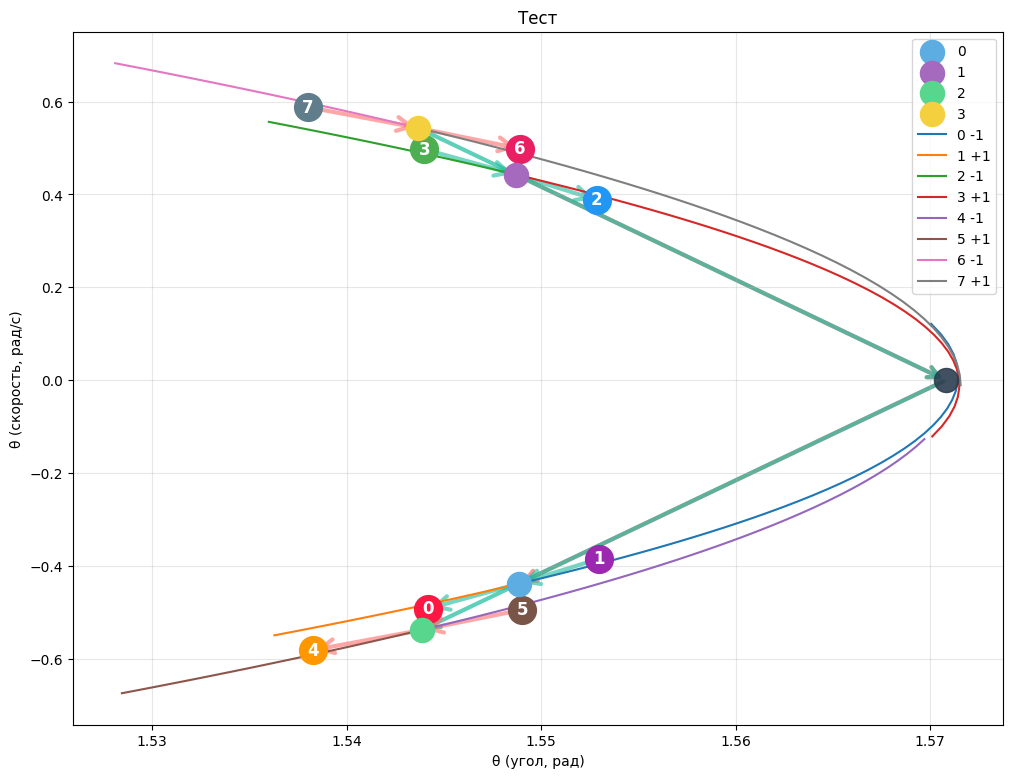

In [7]:
tree = SporeTree(pendulum, cfg)
children = tree.create_children(show=False)
grandchildren = tree.create_grandchildren(show=False)
tree.sort_and_pair_grandchildren()
tree.calculate_mean_points()

# ──────────────────────────────────────────────────────────────────────
# 2. Кэш-оценщик на основе дерева
# ──────────────────────────────────────────────────────────────────────
visualize_spore_tree(tree, "Тест")






dts = [0.005, 0.001, 0.001, 0.005, 0.003, 0.001, 0.001, 0.004]
for i in range(len(children)):
    poses_1 = draw_quad(state=children[i]['position'], time_sign=-1, control=children[i]['control'], N=50, max_dt=dts[2*i])
    poses_2 = draw_quad(state=children[i]['position'], time_sign=+1, control=children[i]['control'], N=50, max_dt=dts[2*i+1])
    plt.plot(poses_1[:, 0], poses_1[:, 1], label=f'{2*i} -1')
    plt.plot(poses_2[:, 0], poses_2[:, 1], label=f'{2*i+1} +1')
plt.legend()


In [8]:
def draw_rk(pendulum, state, time_sign, control, N = 50, total_dt=0.01):
    poses = [state]

    for i in range(1, N+1):
        poses.append(pendulum.step(poses[-1], control, time_sign*total_dt/N*i))

    return np.array(poses)

In [9]:
init_position = np.array([np.pi/2 /2 , 0])

cfg = SporeTreeConfig(
    initial_position=init_position,
    dt_base=0.05,
    dt_grandchildren_factor=0.1,
    figure_size=(10, 10)
)
cfg.validate()

True

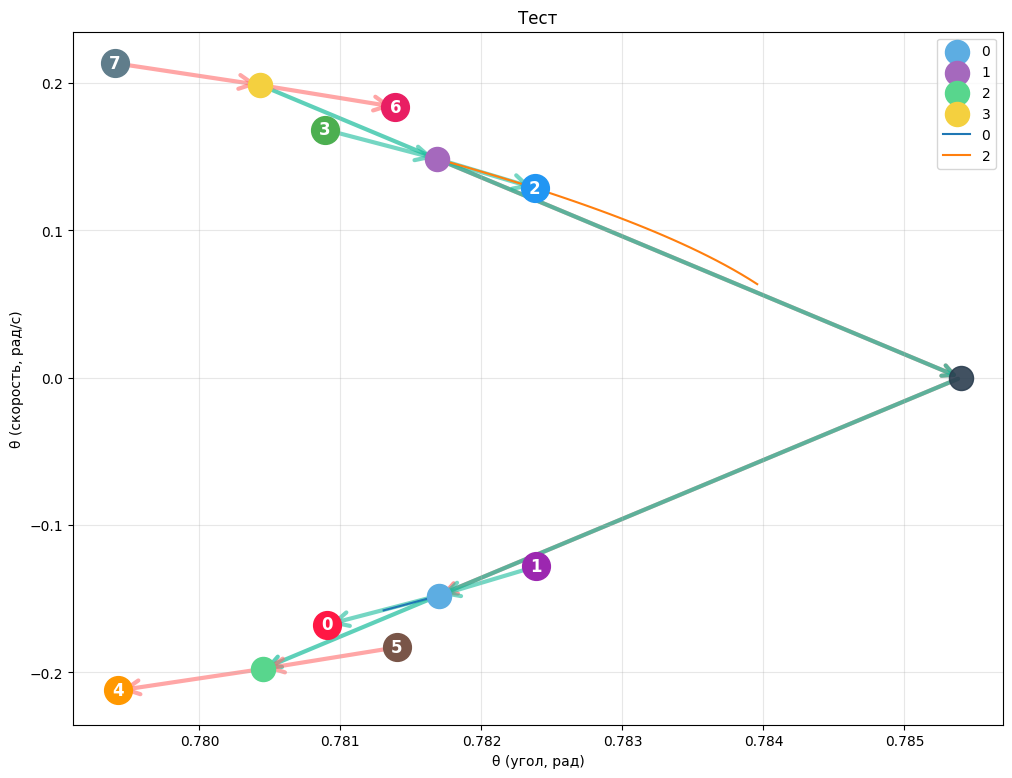

In [10]:
tree = SporeTree(pendulum, cfg)
children = tree.create_children(show=False)
grandchildren = tree.create_grandchildren(show=False)
tree.sort_and_pair_grandchildren()
tree.calculate_mean_points()

# ──────────────────────────────────────────────────────────────────────
# 2. Кэш-оценщик на основе дерева
# ──────────────────────────────────────────────────────────────────────
visualize_spore_tree(tree, "Тест")


poses = []
# dts = [0.01, 0.005, 0.003, 0.003, 0.01, 0.006, 0.003, 0.003]
dts = [0.0001, 0.000, 0.00084, 0.000, 0.000, 0.000, 0.000, 0.000]
dts = np.array(dts)

for i in range(len(grandchildren)):
    parent_pos = children[grandchildren[i]['parent_idx']]['position']
    sign = grandchildren[i]['dt'] / grandchildren[i]['dt_abs']
    control = grandchildren[i]['control']
    poses_1 = draw_rk(pendulum, state=parent_pos, time_sign=sign, control=control, total_dt=dts[i])
    if dts[i] > 0:
        plt.plot(poses_1[:, 0], poses_1[:, 1], label=f'{i}')

plt.legend()


In [11]:
def compute_distance_derivative_table(grandchildren, pendulum, show=False):
    """
    Составляет оптимизированную таблицу первых производных расстояний (только верхний треугольник).
    
    Args:
        grandchildren: список внуков с полями 'position', 'control', 'dt'
        pendulum: объект маятника для вычисления скоростей
        show: выводить таблицу
        
    Returns:
        pandas.DataFrame: симметричная таблица значений d/dt|r_i - r_j|
            Отрицательные: сближаются (чем меньше, тем быстрее)
            Положительные: расходятся (чем больше, тем быстрее)
    """
    import numpy as np
    import pandas as pd
    
    n = len(grandchildren)
    values_table = np.zeros((n, n))
    
    # Вычисляем скорости всех внуков с учетом направления времени
    velocities = []
    for i, gc in enumerate(grandchildren):
        pos = gc['position']
        control = gc['control']
        
        # ИСПРАВЛЕНО: используем знак dt вместо парсинга имени
        time_sign = np.sign(gc['dt'])
        
        # Получаем "обычную" динамику маятника (для времени вперед)
        dynamics = pendulum.pendulum_dynamics(pos, control)  # [theta_dot, theta_ddot]
        
        # ИСПРАВЛЕНО: если время идет назад, обращаем знак по обеим координатам
        velocity_vector = time_sign * dynamics
        velocities.append(velocity_vector)
        
        if show and i < 5:  # Показываем первые 3 для отладки
            print(f"  Внук {i}: dt={gc['dt']:+.6f}, time_sign={time_sign:+1.0f}")
            print(f"    dynamics={dynamics}, velocity={velocity_vector}")
    
    # Заполняем только верхний треугольник (оптимизация в 2 раза)
    for i in range(n):
        for j in range(i+1, n):  # Только j > i
            # Позиции и скорости
            r1 = grandchildren[i]['position']
            r2 = grandchildren[j]['position']
            v1 = velocities[i]
            v2 = velocities[j]
            
            # Вектор между точками и разность скоростей
            r_diff = r1 - r2
            v_diff = v1 - v2
            
            # Текущее расстояние
            distance = np.linalg.norm(r_diff)
            
            if distance < 1e-10:
                derivative_value = 0.0
            else:
                # Производная расстояния: d/dt |r1 - r2| = (r1-r2)·(v1-v2) / |r1-r2|
                derivative_value = np.dot(r_diff, v_diff) / distance
            
            # Заполняем симметрично
            values_table[i, j] = derivative_value
            values_table[j, i] = derivative_value
    
    # Создаем pandas DataFrame
    df = pd.DataFrame(values_table, 
                     index=[f"gc_{i}" for i in range(n)],
                     columns=[f"gc_{i}" for i in range(n)])
    
    if show:
        print("📊 Таблица ПЕРВЫХ производных расстояний d/dt|r_i - r_j| (ИСПРАВЛЕННАЯ):")
        print("   < 0: сближаются (чем меньше, тем быстрее)")
        print("   = 0: стационарно") 
        print("   > 0: расходятся (чем больше, тем быстрее)")
        print()
        # Форматируем вывод с 4 знаками после запятой
        with pd.option_context('display.precision', 4):
            print(df)
        
        # Дополнительная статистика (только верхний треугольник)
        upper_triangle = df.where(np.triu(np.ones(df.shape), k=1).astype(bool))
        valid_values = upper_triangle.stack().values
        
        negative_count = (valid_values < -1e-6).sum()
        zero_count = ((valid_values >= -1e-6) & (valid_values <= 1e-6)).sum()
        positive_count = (valid_values > 1e-6).sum()
        
        print(f"\nСтатистика:")
        print(f"  Сближающихся пар: {negative_count}")
        print(f"  Стационарных пар: {zero_count}")
        print(f"  Расходящихся пар: {positive_count}")
        print(f"  Всего уникальных пар: {len(valid_values)}")
        
        if negative_count > 0:
            min_val = valid_values[valid_values < -1e-6].min()
            print(f"  Максимальная скорость сближения: {min_val:.6f}")
        if positive_count > 0:
            max_val = valid_values[valid_values > 1e-6].max()
            print(f"  Максимальная скорость расхождения: {max_val:.6f}")
    
    return df

In [12]:

velocities = compute_distance_derivative_table(grandchildren, pendulum, show=True)  

  Внук 0: dt=+0.005000, time_sign=+1
    dynamics=[-0.16752519 -3.93599842], velocity=[-0.16752519 -3.93599842]
  Внук 1: dt=-0.005000, time_sign=-1
    dynamics=[-0.12811862 -3.94508553], velocity=[0.12811862 3.94508553]
  Внук 2: dt=+0.005000, time_sign=+1
    dynamics=[ 0.12872151 -3.97073818], velocity=[ 0.12872151 -3.97073818]
  Внук 3: dt=-0.005000, time_sign=-1
    dynamics=[ 0.16842404 -3.969536  ], velocity=[-0.16842404  3.969536  ]
  Внук 4: dt=+0.005000, time_sign=+1
    dynamics=[-0.21228062 -2.92635103], velocity=[-0.21228062 -2.92635103]
📊 Таблица ПЕРВЫХ производных расстояний d/dt|r_i - r_j| (ИСПРАВЛЕННАЯ):
   < 0: сближаются (чем меньше, тем быстрее)
   = 0: стационарно
   > 0: расходятся (чем больше, тем быстрее)

        gc_0    gc_1    gc_2    gc_3    gc_4    gc_5    gc_6    gc_7
gc_0  0.0000  7.8866 -0.0333  7.9055 -1.0076 -6.8575  0.9637  6.9050
gc_1  7.8866  0.0000 -7.9158  0.0259  6.8792  1.0078 -6.9180 -0.9732
gc_2 -0.0333 -7.9158  0.0000  7.9458 -1.0414 -6.9070

In [13]:
def compute_grandchild_parent_convergence_table(grandchildren, children, pendulum, show=False):
    """
    Составляет таблицу первых производных расстояний между внуками и ЧУЖИМИ родителями.
    
    Args:
        grandchildren: список внуков с полями 'position', 'control', 'dt', 'parent_idx'
        children: список родителей с полями 'position', 'control', 'dt'
        pendulum: объект маятника для вычисления скоростей
        show: выводить таблицу
        
    Returns:
        pandas.DataFrame: таблица d/dt|r_внук - r_родитель|
            Строки: внуки (gc_0, gc_1, ...)
            Столбцы: родители (parent_0, parent_1, ...)
            Значения < 0: сближаются
            Значения > 0: расходятся
            NaN: свой родитель (исключен)
    """
    import numpy as np
    import pandas as pd
    
    n_grandchildren = len(grandchildren)
    n_parents = len(children)
    values_table = np.full((n_grandchildren, n_parents), np.nan)
    
    # Вычисляем скорости внуков
    grandchild_velocities = []
    for gc in grandchildren:
        pos = gc['position']
        control = gc['control']
        time_sign = np.sign(gc['dt'])
        dynamics = pendulum.pendulum_dynamics(pos, control)
        velocity_vector = time_sign * dynamics
        grandchild_velocities.append(velocity_vector)
    
    # Вычисляем скорости родителей
    parent_velocities = []
    for parent in children:
        pos = parent['position']
        control = parent['control']
        time_sign = np.sign(parent['dt'])
        dynamics = pendulum.pendulum_dynamics(pos, control)
        velocity_vector = time_sign * dynamics
        parent_velocities.append(velocity_vector)
    
    # Заполняем таблицу
    for gc_idx, gc in enumerate(grandchildren):
        own_parent_idx = gc['parent_idx']
        
        for parent_idx, parent in enumerate(children):
            # Пропускаем своего родителя
            if parent_idx == own_parent_idx:
                continue
            
            # Позиции и скорости
            gc_pos = gc['position']
            parent_pos = parent['position']
            gc_vel = grandchild_velocities[gc_idx]
            parent_vel = parent_velocities[parent_idx]
            
            # Вектор между точками и разность скоростей
            r_diff = gc_pos - parent_pos
            v_diff = gc_vel - parent_vel
            
            # Текущее расстояние
            distance = np.linalg.norm(r_diff)
            
            if distance < 1e-10:
                derivative_value = 0.0
            else:
                # Производная расстояния: d/dt |r_внук - r_родитель|
                derivative_value = np.dot(r_diff, v_diff) / distance
            
            values_table[gc_idx, parent_idx] = derivative_value
    
    # Создаем pandas DataFrame
    df = pd.DataFrame(values_table,
                     index=[f"gc_{i}" for i in range(n_grandchildren)],
                     columns=[f"parent_{i}" for i in range(n_parents)])
    
    if show:
        print("📊 Таблица сближения внуков с ЧУЖИМИ родителями d/dt|r_внук - r_родитель|:")
        print("   < 0: внук сближается с родителем")
        print("   = 0: стационарно")
        print("   > 0: внук отдаляется от родителя")
        print("   NaN: свой родитель (исключен)")
        print()
        
        # Форматируем вывод
        with pd.option_context('display.precision', 4):
            print(df)
        
        # Статистика по сближениям
        valid_values = df.values[~np.isnan(df.values)]
        
        approaching_count = (valid_values < -1e-6).sum()
        stationary_count = ((valid_values >= -1e-6) & (valid_values <= 1e-6)).sum()
        receding_count = (valid_values > 1e-6).sum()
        
        print(f"\nСтатистика:")
        print(f"  Внуков сближается с чужими родителями: {approaching_count}")
        print(f"  Стационарных: {stationary_count}")
        print(f"  Внуков отдаляется от чужих родителей: {receding_count}")
        print(f"  Всего связей внук-чужой_родитель: {len(valid_values)}")
        
        if approaching_count > 0:
            min_val = valid_values[valid_values < -1e-6].min()
            print(f"  Максимальная скорость сближения: {min_val:.6f}")
        if receding_count > 0:
            max_val = valid_values[valid_values > 1e-6].max()
            print(f"  Максимальная скорость отдаления: {max_val:.6f}")
        
        # Показываем какие внуки к каким родителям сближаются
        print(f"\n🎯 Внуки, сближающиеся с чужими родителями:")
        for gc_idx in range(n_grandchildren):
            approaching_parents = []
            for parent_idx in range(n_parents):
                value = df.iloc[gc_idx, parent_idx]
                if not np.isnan(value) and value < -1e-6:
                    approaching_parents.append(f"parent_{parent_idx}({value:.3f})")
            
            if approaching_parents:
                print(f"  gc_{gc_idx}: {', '.join(approaching_parents)}")
    
    return df

In [22]:
def find_optimal_dt_to_target(grandchild, target_position, pendulum, dt_bounds=(0.001, 0.1), show=False):
    """
    Находит оптимальный dt для минимального расстояния внука до цели.
    
    Args:
        grandchild: словарь внука с полями 'position', 'control', 'dt', 'parent_idx', 'name'
        target_position: np.array([theta, theta_dot]) - позиция цели
        pendulum: объект маятника
        dt_bounds: (min_dt, max_dt) - границы поиска
        show: показать детали оптимизации
        
    Returns:
        dict: {
            'optimal_dt': float,
            'min_distance': float, 
            'final_position': np.array,
            'success': bool,
            'method_used': str
        }
    """
    import numpy as np
    from scipy.optimize import minimize_scalar
    
    # Получаем начальную позицию внука (позицию его родителя)
    parent_position = None
    # Нужно найти родителя по parent_idx - это делается снаружи
    # Пока используем текущую позицию как приближение
    start_position = grandchild['position']  # Это неточно, но для начала
    
    control = grandchild['control']
    
    # Определяем направление времени
    time_sign = np.sign(grandchild['dt'])
    
    def distance_to_target(dt_abs):
        """Функция расстояния до цели для заданного |dt|"""
        dt_signed = time_sign * dt_abs
        
        # Вычисляем позицию внука через время dt_signed
        try:
            final_pos = pendulum.step(start_position, control, dt_signed)
            distance = np.linalg.norm(final_pos - target_position)
            return distance
        except:
            return 1e6  # Большое значение при ошибке
    
    # Пробуем разные методы оптимизации
    methods = ['bounded', 'brent', 'golden']
    best_result = None
    best_distance = float('inf')
    
    for method in methods:
        try:
            if method == 'bounded':
                result = minimize_scalar(
                    distance_to_target,
                    bounds=dt_bounds,
                    method='bounded'
                )
            else:
                result = minimize_scalar(
                    distance_to_target,
                    bracket=(dt_bounds[0], (dt_bounds[0] + dt_bounds[1])/2, dt_bounds[1]),
                    method=method
                )
            
            if result.success and result.fun < best_distance:
                best_result = result
                best_distance = result.fun
                
                if show:
                    print(f"    Метод {method}: success, dt={result.x:.6f}, distance={result.fun:.6f}")
            elif show:
                print(f"    Метод {method}: {'fail' if not result.success else f'worse ({result.fun:.6f})'}")
                
        except Exception as e:
            if show:
                print(f"    Метод {method}: ошибка {e}")
            continue
    
    # Формируем результат
    if best_result is not None:
        optimal_dt = best_result.x
        dt_signed = time_sign * optimal_dt
        final_position = pendulum.step(start_position, control, dt_signed)
        
        return {
            'optimal_dt': optimal_dt,
            'min_distance': best_result.fun,
            'final_position': final_position,
            'dt_signed': dt_signed,
            'success': True,
            'method_used': 'scipy_minimize',
            'iterations': getattr(best_result, 'nit', 0)
        }
    else:
        # Запасной вариант: пробуем несколько точек вручную
        if show:
            print(f"    Оптимизация провалилась, пробуем сетку...")
        
        dt_grid = np.linspace(dt_bounds[0], dt_bounds[1], 20)
        distances = [distance_to_target(dt) for dt in dt_grid]
        
        best_idx = np.argmin(distances)
        optimal_dt = dt_grid[best_idx]
        min_distance = distances[best_idx]
        
        dt_signed = time_sign * optimal_dt
        final_position = pendulum.step(start_position, control, dt_signed)
        
        if show:
            print(f"    Сетка: dt={optimal_dt:.6f}, distance={min_distance:.6f}")
        
        return {
            'optimal_dt': optimal_dt,
            'min_distance': min_distance,
            'final_position': final_position,
            'dt_signed': dt_signed,
            'success': min_distance < 1e5,
            'method_used': 'grid_search',
            'iterations': len(dt_grid)
        }

In [23]:
def analyze_grandchild_options(gc_idx, grandchildren, children, 
                                gc_gc_convergence_df, gc_parent_convergence_df, 
                                pendulum, dt_bounds=(0.001, 0.1), show=False):
    """
    Анализирует все возможности конкретного внука для сближения.
    
    Args:
        gc_idx: индекс анализируемого внука
        grandchildren: список всех внуков
        children: список всех родителей  
        gc_gc_convergence_df: таблица сближения внуков с внуками
        gc_parent_convergence_df: таблица сближения внуков с родителями
        pendulum: объект маятника
        dt_bounds: границы поиска dt
        show: показать детали
        
    Returns:
        dict: {
            'grandchild_idx': int,
            'approaching_parents': list,
            'approaching_grandchildren': list,
            'all_options': list  # упорядоченный список всех возможностей
        }
    """
    import numpy as np
    
    target_gc = grandchildren[gc_idx]
    parent_position = children[target_gc['parent_idx']]['position']  # Позиция родителя
    
    if show:
        print(f"\n🔍 АНАЛИЗ gc_{gc_idx} ({target_gc.get('name', 'unnamed')}):")
        print(f"   Родитель: parent_{target_gc['parent_idx']}")
        print(f"   Управление: {target_gc['control']:+.1f}")
        print(f"   Направление: {'forward' if target_gc['dt'] > 0 else 'backward'}")
    
    approaching_parents = []
    approaching_grandchildren = []
    all_options = []
    
    # ВСПОМОГАТЕЛЬНАЯ ФУНКЦИЯ для поиска оптимального dt
    def find_optimal_dt_to_position(target_pos):
        """Находит оптимальный dt для минимизации расстояния до цели"""
        control = target_gc['control']
        time_sign = np.sign(target_gc['dt'])
        
        def distance_to_target(dt_abs):
            dt_signed = time_sign * dt_abs
            try:
                final_pos = pendulum.step(parent_position, control, dt_signed)
                return np.linalg.norm(final_pos - target_pos)
            except:
                return 1e6
        
        from scipy.optimize import minimize_scalar
        try:
            result = minimize_scalar(distance_to_target, bounds=dt_bounds, method='bounded')
            if result.success:
                optimal_dt = result.x
                dt_signed = time_sign * optimal_dt
                final_pos = pendulum.step(parent_position, control, dt_signed)
                return {
                    'optimal_dt': optimal_dt,
                    'min_distance': result.fun,
                    'final_position': final_pos,
                    'dt_signed': dt_signed,
                    'success': True
                }
        except:
            pass
        
        return {'success': False, 'min_distance': float('inf')}
    
    # АНАЛИЗ 1: Сближение с чужими родителями
    if show:
        print(f"\n   🎯 Чужие родители, с которыми сближается:")
    
    for parent_idx in range(len(children)):
        if parent_idx == target_gc['parent_idx']:
            continue  # Пропускаем своего родителя
            
        convergence_rate = gc_parent_convergence_df.iloc[gc_idx, parent_idx]
        
        if not np.isnan(convergence_rate) and convergence_rate < -1e-6:
            target_parent_pos = children[parent_idx]['position']
            
            opt_result = find_optimal_dt_to_position(target_parent_pos)
            
            if opt_result['success']:
                option = {
                    'type': 'parent',
                    'target_idx': parent_idx,
                    'target_name': f"parent_{parent_idx}",
                    'convergence_rate': convergence_rate,
                    'optimal_dt': opt_result['optimal_dt'],
                    'min_distance': opt_result['min_distance'],
                    'dt_signed': opt_result['dt_signed']
                }
                
                approaching_parents.append(option)
                all_options.append(option)
                
                if show:
                    print(f"     parent_{parent_idx}: скорость={convergence_rate:.4f}, "
                          f"мин_расст={opt_result['min_distance']:.6f}, "
                          f"dt={opt_result['optimal_dt']:.4f}")
    
    # АНАЛИЗ 2: Сближение с другими внуками  
    if show:
        print(f"\n   👶 Другие внуки, с которыми сближается:")
    
    for other_gc_idx in range(len(grandchildren)):
        if other_gc_idx == gc_idx:
            continue
            
        convergence_rate = gc_gc_convergence_df.iloc[gc_idx, other_gc_idx]
        
        if convergence_rate < -1e-6:
            # Тут сложнее - нужно оптимизировать dt для ОБОИХ внуков
            # Пока упрощенно: фиксируем dt второго внука и оптимизируем первого
            other_gc = grandchildren[other_gc_idx]
            
            # Текущая позиция второго внука (как приближение)
            other_current_pos = other_gc['position']
            
            opt_result = find_optimal_dt_to_position(other_current_pos)
            
            if opt_result['success']:
                option = {
                    'type': 'grandchild',
                    'target_idx': other_gc_idx, 
                    'target_name': f"gc_{other_gc_idx}",
                    'convergence_rate': convergence_rate,
                    'optimal_dt': opt_result['optimal_dt'],
                    'min_distance': opt_result['min_distance'],
                    'dt_signed': opt_result['dt_signed']
                }
                
                approaching_grandchildren.append(option)
                all_options.append(option)
                
                if show:
                    print(f"     gc_{other_gc_idx}: скорость={convergence_rate:.4f}, "
                          f"мин_расст={opt_result['min_distance']:.6f}, "
                          f"dt={opt_result['optimal_dt']:.4f}")
    
    # СОРТИРОВКА по минимальному расстоянию
    all_options.sort(key=lambda x: x['min_distance'])
    
    if show:
        print(f"\n   📋 УПОРЯДОЧЕННЫЙ СПИСОК (по мин. расстоянию):")
        if all_options:
            for i, option in enumerate(all_options):
                icon = "🏠" if option['type'] == 'parent' else "👶"
                print(f"     {i+1}. {icon} {option['target_name']}: "
                      f"расст={option['min_distance']:.6f}, "
                      f"dt={option['optimal_dt']:.4f}, "
                      f"скорость={option['convergence_rate']:.4f}")
        else:
            print(f"     (нет подходящих целей)")
    
    return {
        'grandchild_idx': gc_idx,
        'approaching_parents': approaching_parents,
        'approaching_grandchildren': approaching_grandchildren,
        'all_options': all_options
    }

In [24]:
def analyze_grandchild_options(gc_idx, grandchildren, children, 
                                gc_gc_convergence_df, gc_parent_convergence_df, 
                                pendulum, dt_bounds=(0.001, 0.1), show=False):
    """
    Анализирует все возможности конкретного внука для сближения.
    
    Args:
        gc_idx: индекс анализируемого внука
        grandchildren: список всех внуков
        children: список всех родителей  
        gc_gc_convergence_df: таблица сближения внуков с внуками
        gc_parent_convergence_df: таблица сближения внуков с родителями
        pendulum: объект маятника
        dt_bounds: границы поиска dt
        show: показать детали
        
    Returns:
        dict: {
            'grandchild_idx': int,
            'approaching_parents': list,
            'approaching_grandchildren': list,
            'all_options': list,                    # упорядоченный по расстоянию
            'options_by_time': list,                # упорядоченный по времени dt
            'chronological_sequence': list          # хронологическая последовательность встреч
        }
    """
    import numpy as np
    
    target_gc = grandchildren[gc_idx]
    parent_position = children[target_gc['parent_idx']]['position']  # Позиция родителя
    
    if show:
        print(f"\n🔍 АНАЛИЗ gc_{gc_idx} ({target_gc.get('name', 'unnamed')}):")
        print(f"   Родитель: parent_{target_gc['parent_idx']}")
        print(f"   Управление: {target_gc['control']:+.1f}")
        print(f"   Направление: {'forward' if target_gc['dt'] > 0 else 'backward'}")
    
    approaching_parents = []
    approaching_grandchildren = []
    all_options = []
    
    # ВСПОМОГАТЕЛЬНАЯ ФУНКЦИЯ для поиска оптимального dt
    def find_optimal_dt_to_position(target_pos):
        """Находит оптимальный dt для минимизации расстояния до цели"""
        control = target_gc['control']
        time_sign = np.sign(target_gc['dt'])
        
        def distance_to_target(dt_abs):
            dt_signed = time_sign * dt_abs
            try:
                final_pos = pendulum.step(parent_position, control, dt_signed)
                return np.linalg.norm(final_pos - target_pos)
            except:
                return 1e6
        
        from scipy.optimize import minimize_scalar
        try:
            result = minimize_scalar(distance_to_target, bounds=dt_bounds, method='bounded')
            if result.success:
                optimal_dt = result.x
                dt_signed = time_sign * optimal_dt
                final_pos = pendulum.step(parent_position, control, dt_signed)
                return {
                    'optimal_dt': optimal_dt,
                    'min_distance': result.fun,
                    'final_position': final_pos,
                    'dt_signed': dt_signed,
                    'success': True
                }
        except:
            pass
        
        return {'success': False, 'min_distance': float('inf')}
    
    # АНАЛИЗ 1: Сближение с чужими родителями
    if show:
        print(f"\n   🎯 Чужие родители, с которыми сближается:")
    
    for parent_idx in range(len(children)):
        if parent_idx == target_gc['parent_idx']:
            continue  # Пропускаем своего родителя
            
        convergence_rate = gc_parent_convergence_df.iloc[gc_idx, parent_idx]
        
        if not np.isnan(convergence_rate) and convergence_rate < -1e-6:
            target_parent_pos = children[parent_idx]['position']
            
            opt_result = find_optimal_dt_to_position(target_parent_pos)
            
            if opt_result['success']:
                option = {
                    'type': 'parent',
                    'target_idx': parent_idx,
                    'target_name': f"parent_{parent_idx}",
                    'convergence_rate': convergence_rate,
                    'optimal_dt': opt_result['optimal_dt'],
                    'min_distance': opt_result['min_distance'],
                    'dt_signed': opt_result['dt_signed']
                }
                
                approaching_parents.append(option)
                all_options.append(option)
                
                if show:
                    print(f"     parent_{parent_idx}: скорость={convergence_rate:.4f}, "
                          f"мин_расст={opt_result['min_distance']:.6f}, "
                          f"dt={opt_result['optimal_dt']:.4f}")
    
    # АНАЛИЗ 2: Сближение с другими внуками  
    if show:
        print(f"\n   👶 Другие внуки, с которыми сближается:")
    
    for other_gc_idx in range(len(grandchildren)):
        if other_gc_idx == gc_idx:
            continue
            
        convergence_rate = gc_gc_convergence_df.iloc[gc_idx, other_gc_idx]
        
        if convergence_rate < -1e-6:
            # Тут сложнее - нужно оптимизировать dt для ОБОИХ внуков
            # Пока упрощенно: фиксируем dt второго внука и оптимизируем первого
            other_gc = grandchildren[other_gc_idx]
            
            # Текущая позиция второго внука (как приближение)
            other_current_pos = other_gc['position']
            
            opt_result = find_optimal_dt_to_position(other_current_pos)
            
            if opt_result['success']:
                option = {
                    'type': 'grandchild',
                    'target_idx': other_gc_idx, 
                    'target_name': f"gc_{other_gc_idx}",
                    'convergence_rate': convergence_rate,
                    'optimal_dt': opt_result['optimal_dt'],
                    'min_distance': opt_result['min_distance'],
                    'dt_signed': opt_result['dt_signed']
                }
                
                approaching_grandchildren.append(option)
                all_options.append(option)
                
                if show:
                    print(f"     gc_{other_gc_idx}: скорость={convergence_rate:.4f}, "
                          f"мин_расст={opt_result['min_distance']:.6f}, "
                          f"dt={opt_result['optimal_dt']:.4f}")
    
    # СОРТИРОВКА по минимальному расстоянию
    all_options.sort(key=lambda x: x['min_distance'])
    
    # СОРТИРОВКА по времени (создаем копию даже если all_options пустой)
    options_by_time = sorted(all_options, key=lambda x: x['optimal_dt']) if all_options else []
    
    # ХРОНОЛОГИЧЕСКАЯ ПОСЛЕДОВАТЕЛЬНОСТЬ встреч (новый список)
    chronological_sequence = sorted(all_options, key=lambda x: x['optimal_dt']) if all_options else []
    
    if show:
        print(f"\n   📋 УПОРЯДОЧЕННЫЙ СПИСОК (по мин. расстоянию):")
        if all_options:
            for i, option in enumerate(all_options):
                icon = "🏠" if option['type'] == 'parent' else "👶"
                print(f"     {i+1}. {icon} {option['target_name']}: "
                      f"расст={option['min_distance']:.6f}, "
                      f"dt={option['optimal_dt']:.4f}, "
                      f"скорость={option['convergence_rate']:.4f}")
        else:
            print(f"     (нет подходящих целей)")
        
        print(f"\n   ⏱️  УПОРЯДОЧЕННЫЙ СПИСОК (по времени dt):")
        if options_by_time:
            for i, option in enumerate(options_by_time):
                icon = "🏠" if option['type'] == 'parent' else "👶"
                print(f"     {i+1}. {icon} {option['target_name']}: "
                      f"dt={option['optimal_dt']:.4f}, "
                      f"расст={option['min_distance']:.6f}, "
                      f"скорость={option['convergence_rate']:.4f}")
        else:
            print(f"     (нет подходящих целей)")
            
        print(f"\n   🕒 ХРОНОЛОГИЧЕСКАЯ ПОСЛЕДОВАТЕЛЬНОСТЬ ВСТРЕЧ:")
        if chronological_sequence:
            print(f"     📅 Временная шкала для внука gc_{gc_idx}:")
            print(f"     {'Время':>10} | {'Цель':>12} | {'Тип':>8} | {'Расстояние':>12} | {'Скорость':>10}")
            print(f"     {'-'*10}|{'-'*13}|{'-'*9}|{'-'*13}|{'-'*11}")
            
            for i, option in enumerate(chronological_sequence):
                icon = "🏠родитель" if option['type'] == 'parent' else "👶внук"
                time_str = f"{option['optimal_dt']:.4f}с"
                target_str = option['target_name']
                distance_str = f"{option['min_distance']:.6f}"
                velocity_str = f"{option['convergence_rate']:.3f}"
                
                print(f"     {time_str:>10} | {target_str:>12} | {icon:>8} | {distance_str:>12} | {velocity_str:>10}")
                
            # Дополнительная статистика для хронологии
            if len(chronological_sequence) > 1:
                earliest_meeting = chronological_sequence[0]
                latest_meeting = chronological_sequence[-1]
                time_span = latest_meeting['optimal_dt'] - earliest_meeting['optimal_dt']
                
                print(f"     ")
                print(f"     📊 Статистика временной шкалы:")
                print(f"        🚀 Первая встреча: {earliest_meeting['optimal_dt']:.4f}с с {earliest_meeting['target_name']}")
                print(f"        🏁 Последняя встреча: {latest_meeting['optimal_dt']:.4f}с с {latest_meeting['target_name']}")
                print(f"        ⏱️  Временной диапазон: {time_span:.4f}с")
                print(f"        📈 Плотность встреч: {len(chronological_sequence)/time_span:.2f} встреч/сек" if time_span > 0 else "        📈 Все встречи одновременны")
        else:
            print(f"     (нет встреч для отображения)")
    
    return {
        'grandchild_idx': gc_idx,
        'approaching_parents': approaching_parents,
        'approaching_grandchildren': approaching_grandchildren,
        'all_options': all_options,                        # отсортировано по расстоянию
        'options_by_time': options_by_time,                 # отсортировано по времени dt
        'chronological_sequence': chronological_sequence   # хронологическая последовательность
    }

In [25]:
# Тест ИСПРАВЛЕННОЙ системы анализа
print("🚀 ТЕСТИРОВАНИЕ ИСПРАВЛЕННОЙ СИСТЕМЫ АНАЛИЗА")
print("=" * 60)

# Убедитесь что у вас есть дерево с внуками
if not tree._grandchildren_created:
    tree.create_children()
    tree.create_grandchildren()

# Запускаем ИСПРАВЛЕННЫЙ комплексный анализ
results = comprehensive_grandchild_analysis_fixed(  # <- НОВОЕ ИМЯ ФУНКЦИИ
    tree=tree,
    pendulum=pendulum, 
    dt_bounds=(0.001, 0.1),
    show=True
)

print("\n✅ Анализ завершен!")

🚀 ТЕСТИРОВАНИЕ ИСПРАВЛЕННОЙ СИСТЕМЫ АНАЛИЗА
🔍 КОМПЛЕКСНЫЙ АНАЛИЗ ВОЗМОЖНОСТЕЙ ВНУКОВ (ИСПРАВЛЕННАЯ ВЕРСИЯ)
📊 ШАГ 1: Таблица сближения внуков с другими внуками
--------------------------------------------------
  Внук 0: dt=+0.005000, time_sign=+1
    dynamics=[-0.16752519 -3.93599842], velocity=[-0.16752519 -3.93599842]
  Внук 1: dt=-0.005000, time_sign=-1
    dynamics=[-0.12811862 -3.94508553], velocity=[0.12811862 3.94508553]
  Внук 2: dt=+0.005000, time_sign=+1
    dynamics=[ 0.12872151 -3.97073818], velocity=[ 0.12872151 -3.97073818]
  Внук 3: dt=-0.005000, time_sign=-1
    dynamics=[ 0.16842404 -3.969536  ], velocity=[-0.16842404  3.969536  ]
  Внук 4: dt=+0.005000, time_sign=+1
    dynamics=[-0.21228062 -2.92635103], velocity=[-0.21228062 -2.92635103]
📊 Таблица ПЕРВЫХ производных расстояний d/dt|r_i - r_j| (ИСПРАВЛЕННАЯ):
   < 0: сближаются (чем меньше, тем быстрее)
   = 0: стационарно
   > 0: расходятся (чем больше, тем быстрее)

        gc_0    gc_1    gc_2    gc_3    gc_4    g

In [26]:
def find_converging_grandchild_pairs(gc_gc_convergence_df, show=False):
    """
    Находит все пары внуков с отрицательными скоростями сближения.
    
    Args:
        gc_gc_convergence_df: таблица скоростей сближения внуков
        show: показать найденные пары
        
    Returns:
        list: список словарей с парами {'gc_i': int, 'gc_j': int, 'velocity': float}
    """
    import numpy as np
    
    converging_pairs = []
    n = len(gc_gc_convergence_df)
    
    # Проходим только верхний треугольник (избегаем дублирования)
    for i in range(n):
        for j in range(i+1, n):
            velocity = gc_gc_convergence_df.iloc[i, j]
            
            if velocity < -1e-6:  # Сближаются
                converging_pairs.append({
                    'gc_i': i,
                    'gc_j': j,
                    'velocity': velocity,
                    'pair_name': f"gc_{i}-gc_{j}"
                })
    
    if show:
        print(f"🎯 Найдено {len(converging_pairs)} сближающихся пар внуков:")
        for pair in converging_pairs:
            print(f"  {pair['pair_name']}: скорость сближения = {pair['velocity']:.6f}")
    
    return converging_pairs


def optimize_grandchild_pair_distance(gc_i_idx, gc_j_idx, grandchildren, children, pendulum, 
                                     dt_bounds=(0.001, 0.1), show=False):
    """
    Оптимизирует dt для ОБОИХ внуков в паре для минимизации расстояния между ними.
    
    Args:
        gc_i_idx, gc_j_idx: индексы внуков в паре
        grandchildren: список всех внуков
        children: список всех родителей
        pendulum: объект маятника
        dt_bounds: границы поиска dt
        show: показать детали оптимизации
        
    Returns:
        dict: {
            'success': bool,
            'min_distance': float,
            'optimal_dt_i': float, 
            'optimal_dt_j': float,
            'final_position_i': np.array,
            'final_position_j': np.array,
            'method_used': str
        }
    """
    import numpy as np
    from scipy.optimize import minimize
    
    gc_i = grandchildren[gc_i_idx]
    gc_j = grandchildren[gc_j_idx]
    
    # Позиции родителей (стартовые точки)
    parent_i_pos = children[gc_i['parent_idx']]['position']
    parent_j_pos = children[gc_j['parent_idx']]['position']
    
    # Направления времени
    time_sign_i = np.sign(gc_i['dt'])
    time_sign_j = np.sign(gc_j['dt'])
    
    def distance_function(dt_params):
        """Функция расстояния между двумя движущимися внуками"""
        dt_abs_i, dt_abs_j = dt_params
        
        try:
            # Вычисляем финальные позиции обоих внуков
            dt_signed_i = time_sign_i * dt_abs_i
            dt_signed_j = time_sign_j * dt_abs_j
            
            pos_i = pendulum.step(parent_i_pos, gc_i['control'], dt_signed_i)
            pos_j = pendulum.step(parent_j_pos, gc_j['control'], dt_signed_j)
            
            # Расстояние между ними
            distance = np.linalg.norm(pos_i - pos_j)
            
            return distance
            
        except Exception as e:
            if show:
                print(f"    ❌ Ошибка в distance_function: {e}")
            return 1e6
    
    # Пробуем разные методы оптимизации
    methods = ['L-BFGS-B', 'Nelder-Mead', 'Powell']
    bounds = [dt_bounds, dt_bounds]  # Границы для обоих dt
    
    best_result = None
    best_distance = float('inf')
    
    for method in methods:
        try:
            x0 = [0.01, 0.01]  # Начальное приближение
            
            if method == 'L-BFGS-B':
                result = minimize(
                    distance_function,
                    x0=x0,
                    bounds=bounds,
                    method=method,
                    options={'ftol': 1e-9, 'gtol': 1e-6}
                )
            else:
                result = minimize(
                    distance_function,
                    x0=x0,
                    method=method,
                    options={'ftol': 1e-9}
                )
            
            if show:
                print(f"    Метод {method}: success={result.success}, fun={result.fun:.2e}")
            
            if result.success and result.fun < best_distance:
                best_result = result
                best_distance = result.fun
                
        except Exception as e:
            if show:
                print(f"    Метод {method}: ошибка {e}")
            continue
    
    # Формируем результат
    if best_result is not None and best_distance < 1e5:
        optimal_dt_i, optimal_dt_j = best_result.x
        
        # Вычисляем финальные позиции
        dt_signed_i = time_sign_i * optimal_dt_i
        dt_signed_j = time_sign_j * optimal_dt_j
        
        final_pos_i = pendulum.step(parent_i_pos, gc_i['control'], dt_signed_i)
        final_pos_j = pendulum.step(parent_j_pos, gc_j['control'], dt_signed_j)
        
        return {
            'success': True,
            'min_distance': best_distance,
            'optimal_dt_i': optimal_dt_i,
            'optimal_dt_j': optimal_dt_j,
            'dt_signed_i': dt_signed_i,
            'dt_signed_j': dt_signed_j,
            'final_position_i': final_pos_i,
            'final_position_j': final_pos_j,
            'method_used': 'scipy_optimize',
            'iterations': getattr(best_result, 'nit', 0)
        }
    else:
        return {
            'success': False,
            'min_distance': float('inf'),
            'method_used': 'failed'
        }


def build_grandchild_pair_tables(tree, pendulum, dt_bounds=(0.001, 0.1), show=False):
    """
    Строит две таблицы для пар внуков:
    1. Минимальные достижимые расстояния
    2. Времена достижения (асимметричная таблица)
    
    Args:
        tree: объект SporeTree
        pendulum: объект маятника
        dt_bounds: границы поиска dt
        show: показать процесс и результаты
        
    Returns:
        dict: {
            'distance_table': DataFrame,  # минимальные расстояния
            'time_table_i': DataFrame,    # времена для внука i
            'time_table_j': DataFrame,    # времена для внука j  
            'optimization_results': dict  # детальные результаты
        }
    """
    import numpy as np
    import pandas as pd
    
    if show:
        print("🔍 АНАЛИЗ ПАР ВНУКОВ С ДВУМЯ АКТИВНЫМИ УЧАСТНИКАМИ")
        print("=" * 70)
    
    # Шаг 1: Получаем таблицу скоростей сближения
    gc_gc_convergence = compute_distance_derivative_table(
        tree.grandchildren, pendulum, show=False
    )
    
    # Шаг 2: Находим сближающиеся пары
    converging_pairs = find_converging_grandchild_pairs(
        gc_gc_convergence, show=show
    )
    
    if not converging_pairs:
        if show:
            print("❌ Нет сближающихся пар внуков!")
        return None
    
    # Шаг 3: Инициализируем таблицы
    n = len(tree.grandchildren)
    distance_table = np.full((n, n), np.nan)
    time_table_i = np.full((n, n), np.nan)  # время для внука i
    time_table_j = np.full((n, n), np.nan)  # время для внука j
    
    optimization_results = {}
    
    if show:
        print(f"\n🔧 Оптимизация {len(converging_pairs)} пар внуков:")
    
    # Шаг 4: Оптимизируем каждую пару
    for pair in converging_pairs:
        gc_i_idx = pair['gc_i']
        gc_j_idx = pair['gc_j']
        pair_name = pair['pair_name']
        
        if show:
            print(f"\n  🎯 Пара {pair_name} (скорость: {pair['velocity']:.6f}):")
        
        result = optimize_grandchild_pair_distance(
            gc_i_idx, gc_j_idx, 
            tree.grandchildren, tree.children, pendulum,
            dt_bounds=dt_bounds, show=show
        )
        
        optimization_results[pair_name] = result
        
        if result['success']:
            # Заполняем таблицы (симметрично для расстояний, асимметрично для времен)
            distance_table[gc_i_idx, gc_j_idx] = result['min_distance']
            distance_table[gc_j_idx, gc_i_idx] = result['min_distance']  # Симметрично
            
            time_table_i[gc_i_idx, gc_j_idx] = result['optimal_dt_i']  # Время для внука i
            time_table_j[gc_i_idx, gc_j_idx] = result['optimal_dt_j']  # Время для внука j
            
            # Обратная пара (j->i) - меняем местами времена
            time_table_i[gc_j_idx, gc_i_idx] = result['optimal_dt_j']  # Время для внука j (теперь i)
            time_table_j[gc_j_idx, gc_i_idx] = result['optimal_dt_i']  # Время для внука i (теперь j)
            
            if show:
                print(f"    ✅ Успех: расст={result['min_distance']:.6f}, "
                      f"dt_i={result['optimal_dt_i']:.4f}, dt_j={result['optimal_dt_j']:.4f}")
        else:
            if show:
                print(f"    ❌ Оптимизация не удалась")
    
    # Шаг 5: Создаем DataFrame
    row_names = [f"gc_{i}" for i in range(n)]
    col_names = [f"gc_{i}" for i in range(n)]
    
    distance_df = pd.DataFrame(distance_table, index=row_names, columns=col_names)
    time_i_df = pd.DataFrame(time_table_i, index=row_names, columns=col_names)
    time_j_df = pd.DataFrame(time_table_j, index=row_names, columns=col_names)
    
    if show:
        print(f"\n📊 РЕЗУЛЬТИРУЮЩИЕ ТАБЛИЦЫ:")
        print("=" * 50)
        
        print(f"\n1️⃣  ТАБЛИЦА МИНИМАЛЬНЫХ РАССТОЯНИЙ (симметричная):")
        with pd.option_context('display.precision', 6):
            print(distance_df)
        
        print(f"\n2️⃣  ТАБЛИЦА ВРЕМЕН ДЛЯ ВНУКА I (строка → столбец):")
        print("   (время которое нужно внуку из строки для встречи с внуком из столбца)")
        with pd.option_context('display.precision', 3):
            print(time_i_df)
        
        print(f"\n3️⃣  ТАБЛИЦА ВРЕМЕН ДЛЯ ВНУКА J (строка → столбец):")
        print("   (время которое нужно внуку из столбца для встречи с внуком из строки)")
        with pd.option_context('display.precision', 3):
            print(time_j_df)
        
        # Статистика
        valid_distances = distance_df.values[~np.isnan(distance_df.values)]
        if len(valid_distances) > 0:
            print(f"\n📈 СТАТИСТИКА:")
            print(f"   Успешных оптимизаций: {len(valid_distances)}")
            print(f"   Минимальное расстояние: {np.min(valid_distances):.8f}")
            print(f"   Максимальное расстояние: {np.max(valid_distances):.8f}")
            print(f"   Среднее расстояние: {np.mean(valid_distances):.8f}")
            
            # Найти лучшую пару
            min_idx = np.unravel_index(np.nanargmin(distance_df.values), distance_df.shape)
            best_i, best_j = min_idx
            best_distance = distance_df.iloc[best_i, best_j]
            best_time_i = time_i_df.iloc[best_i, best_j]
            best_time_j = time_j_df.iloc[best_i, best_j]
            
            print(f"\n🏆 ЛУЧШАЯ ПАРА:")
            print(f"   gc_{best_i} ↔ gc_{best_j}: расстояние = {best_distance:.8f}")
            print(f"   Времена: dt_i={best_time_i:.6f}, dt_j={best_time_j:.6f}")
    
    return {
        'distance_table': distance_df,
        'time_table_i': time_i_df,
        'time_table_j': time_j_df,
        'optimization_results': optimization_results,
        'converging_pairs': converging_pairs
    }

In [27]:
def analyze_grandchild_pair_strategies(pair_results, show=False):
    """
    Анализирует результаты оптимизации пар внуков и предлагает стратегии.
    
    Args:
        pair_results: результат от build_grandchild_pair_tables()
        show: показать анализ
        
    Returns:
        dict: различные стратегии выбора пар
    """
    import numpy as np
    import pandas as pd
    
    if pair_results is None:
        if show:
            print("❌ Нет данных для анализа")
        return None
    
    distance_df = pair_results['distance_table']
    time_i_df = pair_results['time_table_i'] 
    time_j_df = pair_results['time_table_j']
    optimization_results = pair_results['optimization_results']
    
    if show:
        print("📊 АНАЛИЗ СТРАТЕГИЙ ВЫБОРА ПАР ВНУКОВ")
        print("=" * 60)
    
    # Стратегия 1: Минимальное расстояние (глобальный оптимум)
    valid_mask = ~np.isnan(distance_df.values)
    if not valid_mask.any():
        if show:
            print("❌ Нет валидных пар для анализа")
        return None
    
    # Находим лучшие пары по разным критериям
    strategies = {}
    
    # 1. Стратегия "Лучшая точность"
    min_distance_idx = np.unravel_index(np.nanargmin(distance_df.values), distance_df.shape)
    best_accuracy_i, best_accuracy_j = min_distance_idx
    best_distance = distance_df.iloc[best_accuracy_i, best_accuracy_j]
    
    strategies['best_accuracy'] = {
        'gc_i': best_accuracy_i,
        'gc_j': best_accuracy_j, 
        'distance': best_distance,
        'dt_i': time_i_df.iloc[best_accuracy_i, best_accuracy_j],
        'dt_j': time_j_df.iloc[best_accuracy_i, best_accuracy_j],
        'description': 'Минимальное расстояние между внуками'
    }
    
    # 2. Стратегия "Минимальное время для первого внука"
    min_time_i_idx = np.unravel_index(np.nanargmin(time_i_df.values), time_i_df.shape)
    fastest_i_i, fastest_i_j = min_time_i_idx
    
    strategies['fastest_for_i'] = {
        'gc_i': fastest_i_i,
        'gc_j': fastest_i_j,
        'distance': distance_df.iloc[fastest_i_i, fastest_i_j],
        'dt_i': time_i_df.iloc[fastest_i_i, fastest_i_j],
        'dt_j': time_j_df.iloc[fastest_i_i, fastest_i_j],
        'description': 'Минимальное время для первого внука'
    }
    
    # 3. Стратегия "Минимальное время для второго внука"
    min_time_j_idx = np.unravel_index(np.nanargmin(time_j_df.values), time_j_df.shape)
    fastest_j_i, fastest_j_j = min_time_j_idx
    
    strategies['fastest_for_j'] = {
        'gc_i': fastest_j_i,
        'gc_j': fastest_j_j,
        'distance': distance_df.iloc[fastest_j_i, fastest_j_j],
        'dt_i': time_i_df.iloc[fastest_j_i, fastest_j_j],
        'dt_j': time_j_df.iloc[fastest_j_i, fastest_j_j],
        'description': 'Минимальное время для второго внука'
    }
    
    # 4. Стратегия "Минимальное суммарное время"
    total_time_table = time_i_df + time_j_df
    min_total_time_idx = np.unravel_index(np.nanargmin(total_time_table.values), total_time_table.shape)
    min_total_i, min_total_j = min_total_time_idx
    
    strategies['min_total_time'] = {
        'gc_i': min_total_i,
        'gc_j': min_total_j,
        'distance': distance_df.iloc[min_total_i, min_total_j],
        'dt_i': time_i_df.iloc[min_total_i, min_total_j],
        'dt_j': time_j_df.iloc[min_total_i, min_total_j],
        'total_time': total_time_table.iloc[min_total_i, min_total_j],
        'description': 'Минимальная сумма времен обоих внуков'
    }
    
    # 5. Стратегия "Балансированный компромисс" 
    # Нормализуем расстояния и времена, затем находим минимум взвешенной суммы
    valid_distances = distance_df.values[~np.isnan(distance_df.values)]
    valid_times_i = time_i_df.values[~np.isnan(time_i_df.values)]
    valid_times_j = time_j_df.values[~np.isnan(time_j_df.values)]
    
    if len(valid_distances) > 1:
        # Нормализация от 0 до 1
        norm_distance = (distance_df - np.nanmin(distance_df)) / (np.nanmax(distance_df) - np.nanmin(distance_df))
        norm_time_i = (time_i_df - np.nanmin(time_i_df)) / (np.nanmax(time_i_df) - np.nanmin(time_i_df))
        norm_time_j = (time_j_df - np.nanmin(time_j_df)) / (np.nanmax(time_j_df) - np.nanmin(time_j_df))
        
        # Взвешенная сумма (равные веса)
        composite_score = 0.5 * norm_distance + 0.25 * norm_time_i + 0.25 * norm_time_j
        min_composite_idx = np.unravel_index(np.nanargmin(composite_score.values), composite_score.shape)
        balanced_i, balanced_j = min_composite_idx
        
        strategies['balanced'] = {
            'gc_i': balanced_i,
            'gc_j': balanced_j,
            'distance': distance_df.iloc[balanced_i, balanced_j],
            'dt_i': time_i_df.iloc[balanced_i, balanced_j],
            'dt_j': time_j_df.iloc[balanced_i, balanced_j],
            'composite_score': composite_score.iloc[balanced_i, balanced_j],
            'description': 'Балансированный компромисс между точностью и скоростью'
        }
    
    if show:
        print("\n🎯 РЕКОМЕНДОВАННЫЕ СТРАТЕГИИ:")
        print("-" * 40)
        
        for strategy_name, strategy in strategies.items():
            if strategy_name == 'min_total_time':
                time_info = f"суммарное время = {strategy['total_time']:.4f}с"
            else:
                time_info = f"dt_i={strategy['dt_i']:.4f}с, dt_j={strategy['dt_j']:.4f}с"
            
            print(f"\n📌 {strategy['description'].upper()}:")
            print(f"   🎯 Пара: gc_{strategy['gc_i']} ↔ gc_{strategy['gc_j']}")
            print(f"   📏 Расстояние: {strategy['distance']:.8f}")
            print(f"   ⏱️  {time_info}")
            
            if 'composite_score' in strategy:
                print(f"   📊 Композитный балл: {strategy['composite_score']:.4f}")
        
        # Анализ различий между стратегиями
        print(f"\n🔍 СРАВНЕНИЕ СТРАТЕГИЙ:")
        print("-" * 30)
        
        strategy_list = list(strategies.keys())
        for i, name in enumerate(strategy_list):
            strategy = strategies[name]
            accuracy_rank = i + 1  # упрощенный рейтинг
            time_sum = strategy['dt_i'] + strategy['dt_j']
            
            print(f"{name:>15}: расст={strategy['distance']:.6f}, время={time_sum:.4f}с")
        
        # Рекомендация
        print(f"\n💡 РЕКОМЕНДАЦИЯ:")
        if 'balanced' in strategies:
            rec = strategies['balanced']
            print(f"   Рекомендуется БАЛАНСИРОВАННАЯ стратегия:")
            print(f"   gc_{rec['gc_i']} ↔ gc_{rec['gc_j']} с расстоянием {rec['distance']:.6f}")
        else:
            rec = strategies['best_accuracy']
            print(f"   Рекомендуется стратегия ЛУЧШЕЙ ТОЧНОСТИ:")
            print(f"   gc_{rec['gc_i']} ↔ gc_{rec['gc_j']} с расстоянием {rec['distance']:.6f}")
    
    return {
        'strategies': strategies,
        'tables': {
            'distance': distance_df,
            'time_i': time_i_df,
            'time_j': time_j_df
        },
        'recommendation': strategies.get('balanced', strategies.get('best_accuracy'))
    }

In [28]:
def comprehensive_grandchild_analysis_fixed(tree, pendulum, dt_bounds=(0.001, 0.1), show=True):
    """
    ИСПРАВЛЕННАЯ версия комплексного анализа всех внуков.
    """
    
    if not tree._grandchildren_created:
        raise RuntimeError("Сначала создайте внуков через tree.create_grandchildren()")
    
    if show:
        print("🔍 КОМПЛЕКСНЫЙ АНАЛИЗ ВОЗМОЖНОСТЕЙ ВНУКОВ (ИСПРАВЛЕННАЯ ВЕРСИЯ)")
        print("=" * 80)
    
    # ШАГ 1: Строим таблицу сближения внуков с внуками
    if show:
        print("📊 ШАГ 1: Таблица сближения внуков с другими внуками")
        print("-" * 50)
    
    gc_gc_convergence = compute_distance_derivative_table(
        tree.grandchildren, pendulum, show=show
    )
    
    # ШАГ 2: Строим таблицу сближения внуков с чужими родителями
    if show:
        print("\n📊 ШАГ 2: Таблица сближения внуков с чужими родителями")
        print("-" * 50)
    
    gc_parent_convergence = compute_grandchild_parent_convergence_table(
        tree.grandchildren, tree.children, pendulum, show=show
    )
    
    # ШАГ 3: Анализ каждого внука индивидуально
    if show:
        print("\n🔍 ШАГ 3: Индивидуальный анализ каждого внука")
        print("-" * 50)
    
    individual_analyses = []
    
    for gc_idx in range(len(tree.grandchildren)):
        analysis = analyze_grandchild_options(
            gc_idx=gc_idx,
            grandchildren=tree.grandchildren,
            children=tree.children,
            gc_gc_convergence_df=gc_gc_convergence,
            gc_parent_convergence_df=gc_parent_convergence,
            pendulum=pendulum,
            dt_bounds=dt_bounds,
            show=show
        )
        individual_analyses.append(analysis)
    
    # ШАГ 4: Общая сводка
    if show:
        print("\n" + "=" * 80)
        print("📋 ОБЩАЯ СВОДКА ПО ВСЕМ ВНУКАМ")
        print("=" * 80)
        
        total_parent_options = 0
        total_gc_options = 0
        best_options_per_gc = []
        
        for analysis in individual_analyses:
            gc_idx = analysis['grandchild_idx']
            n_parents = len(analysis['approaching_parents'])
            n_gcs = len(analysis['approaching_grandchildren'])
            
            total_parent_options += n_parents
            total_gc_options += n_gcs
            
            if analysis['all_options']:
                best_option = analysis['all_options'][0]  # Первый в отсортированном списке
                best_options_per_gc.append((gc_idx, best_option))
            
            print(f"gc_{gc_idx}: {n_parents} родителей + {n_gcs} внуков = {n_parents + n_gcs} опций")
        
        print(f"\nИТОГО:")
        print(f"  Всего связей с родителями: {total_parent_options}")
        print(f"  Всего связей с внуками: {total_gc_options}")
        print(f"  Внуков с опциями: {len([a for a in individual_analyses if a['all_options']])}/{len(individual_analyses)}")
        
        # ТОП лучших опций
        if best_options_per_gc:
            print(f"\n🏆 ТОП ЛУЧШИХ ОПЦИЙ (по минимальному расстоянию):")
            best_options_per_gc.sort(key=lambda x: x[1]['min_distance'])
            
            for i, (gc_idx, option) in enumerate(best_options_per_gc[:5]):  # Топ 5
                icon = "🏠" if option['type'] == 'parent' else "👶"
                print(f"  {i+1}. gc_{gc_idx} → {icon} {option['target_name']}: "
                      f"{option['min_distance']:.5f} (dt={option['optimal_dt']:.5f})")
                      
            # ТОП по времени - ИСПРАВЛЕННЫЙ КОД
            print(f"\n⏱️  ТОП БЫСТРЫХ ОПЦИЙ (по минимальному времени):")
            best_by_time = []
            for gc_idx, analysis in enumerate(individual_analyses):
                # Проверяем наличие ключа и содержимого
                if 'options_by_time' in analysis and isinstance(analysis['options_by_time'], list) and len(analysis['options_by_time']) > 0:
                    best_by_time.append((gc_idx, analysis['options_by_time'][0]))
            
            if best_by_time:
                best_by_time.sort(key=lambda x: x[1]['optimal_dt'])
                
                for i, (gc_idx, option) in enumerate(best_by_time[:5]):  # Топ 5
                    icon = "🏠" if option['type'] == 'parent' else "👶"
                    print(f"  {i+1}. gc_{gc_idx} → {icon} {option['target_name']}: "
                          f"dt={option['optimal_dt']:.5f} (расст={option['min_distance']:.5f})")
            else:
                print(f"  (нет быстрых опций для отображения)")
        
        # Статистика по типам целей
        if best_options_per_gc:
            all_best_options = [opt for _, opt in best_options_per_gc]
            parent_targets = [opt for opt in all_best_options if opt['type'] == 'parent']
            gc_targets = [opt for opt in all_best_options if opt['type'] == 'grandchild']
            
            print(f"\n📊 СТАТИСТИКА ЛУЧШИХ ОПЦИЙ:")
            print(f"  Предпочитают родителей: {len(parent_targets)}")
            print(f"  Предпочитают внуков: {len(gc_targets)}")
            
            if parent_targets:
                avg_parent_dist = sum(opt['min_distance'] for opt in parent_targets) / len(parent_targets)
                avg_parent_time = sum(opt['optimal_dt'] for opt in parent_targets) / len(parent_targets)
                print(f"  Средняя дистанция до родителей: {avg_parent_dist:.5f}")
                print(f"  Среднее время до родителей: {avg_parent_time:.5f}")
            
            if gc_targets:
                avg_gc_dist = sum(opt['min_distance'] for opt in gc_targets) / len(gc_targets)
                avg_gc_time = sum(opt['optimal_dt'] for opt in gc_targets) / len(gc_targets)
                print(f"  Средняя дистанция до внуков: {avg_gc_dist:.5f}")
                print(f"  Среднее время до внуков: {avg_gc_time:.5f}")
    
    return {
        'gc_gc_convergence': gc_gc_convergence,
        'gc_parent_convergence': gc_parent_convergence,
        'individual_analyses': individual_analyses
    }

In [32]:
# Полный анализ пар внуков (оба активных)
results = complete_grandchild_pair_analysis_fixed(
    tree=tree,
    pendulum=pendulum, 
    dt_bounds=(0.001, 0.1),
    show=True
)

NameError: name 'complete_grandchild_pair_analysis_fixed' is not defined

In [30]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)